In [1]:
import tqdm
import json
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from zeo_amd.plotting import savefig

plt.style.use("jupyter")

## Loading the data

We are going to load the data for the hyperparameter search of a balanced classifier.

In [2]:
df = pd.read_json("../data/hparams_rnd_soap_balanced.json")

df["params_str"] = df["params"].apply(json.dumps)

In [3]:
num_points = df[["label", "n_pos"]].drop_duplicates().set_index("label").rename(columns={"n_pos": "n"})

# the training set is balanced: 50-50 positive-negative, so the total number of points
# is twice the number of positive points

num_points = num_points * 2

In [4]:
meandf = (df
    .groupby(["label", "classifier", "params_str"])
    .mean()
    .reset_index()
)

meandf = meandf.drop([
    "run", "n_pos", "n_neg", "seed",
    "params_index",
], axis=1)

stddf = (df
    .groupby(["label", "classifier", "params_str"])
    .std()
    .reset_index()
)

stddf = stddf.drop([
    "run", "n_pos", "n_neg", "seed",
    "params_index",
], axis=1)

In [5]:
COLORS = {
    "LogisticRegression": cm.tab10(0),
    "RandomForestClassifier": cm.tab10(1),
    "XGBClassifier": cm.tab10(2),
}
METRICS = ['val_accuracy', 'val_precision', 'val_recall', 'val_F1-score', 'val_roc_auc', 'val_pr_auc']
LABELS = ['Al', 'B', 'Be', 'Ca', 'Co', 'F', 'Ga', 'Ge', 'K', 'Mg', 'Na', 'P', 'Si', 'Zn']

## Visualizing metrics of the classifiers

### PR AUC vs ROC AUC

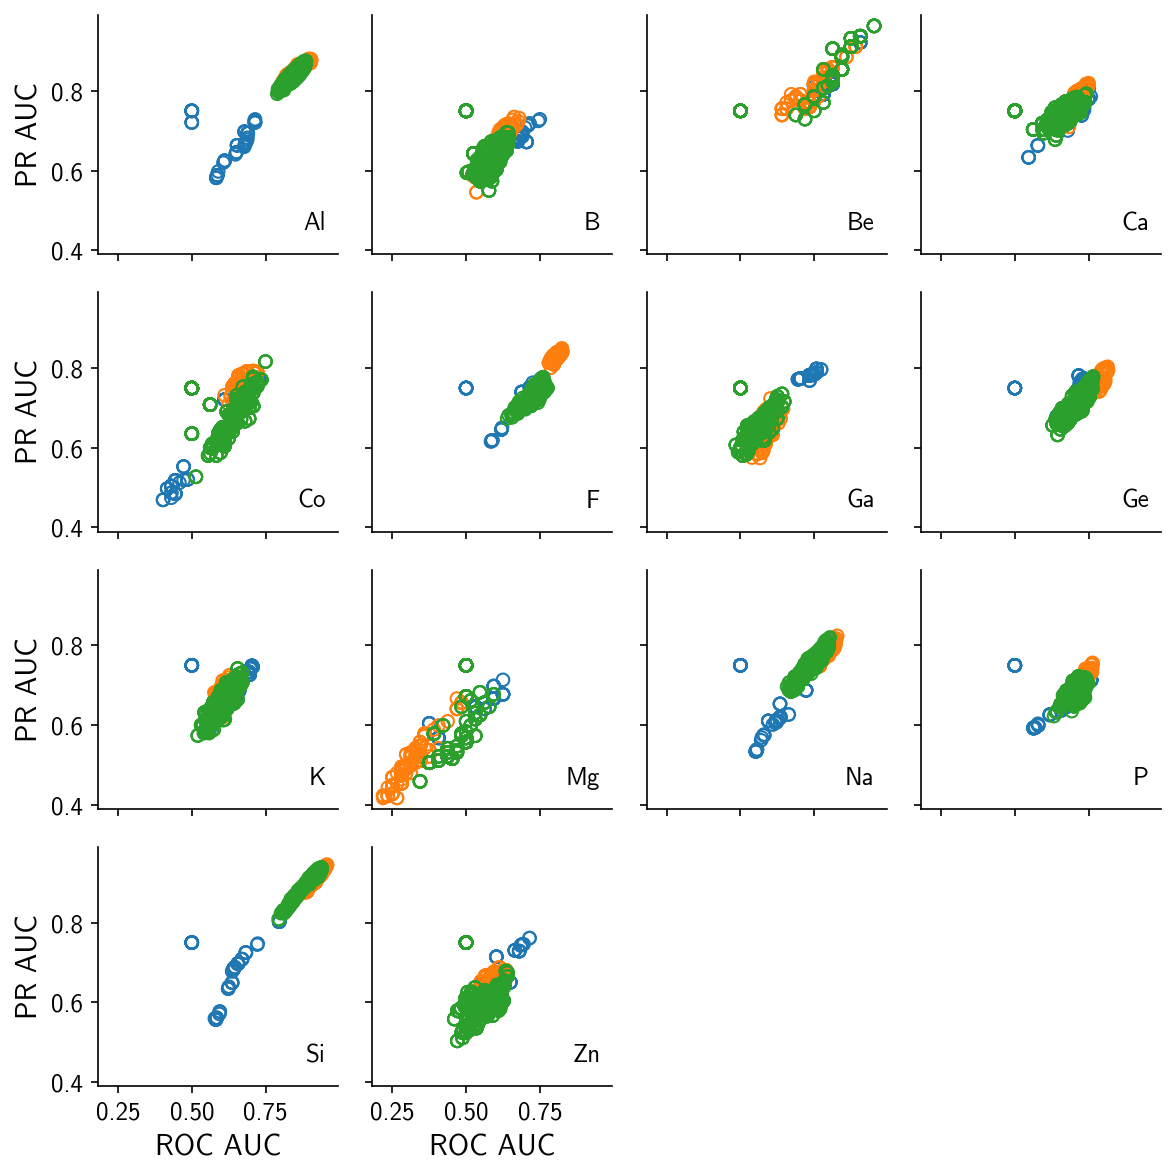

In [6]:
fig, ax_fig = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)

_x = np.arange(len(METRICS))

for ax, label in zip(ax_fig.reshape(-1), LABELS):
    _df = meandf.loc[(meandf.label == label)]
    _std = stddf.loc[_df.index]
    
    for clf, grp in _df.groupby("classifier"):
        std_grp = _std.loc[grp.index]
        
        ax.scatter(
            grp["val_roc_auc"],
            grp["val_pr_auc"],
            label=clf,
            facecolors="none",
            edgecolors=COLORS[clf],
        )

    ax.annotate(label, (0.95, 0.1), xycoords="axes fraction", ha='right')

for ax in ax_fig[-1, :]:
    ax.set_xlabel("ROC AUC")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("PR AUC")

for ax in ax_fig.reshape(-1)[-2:]:
    ax.axis("off")
    
fig.tight_layout()

savefig(fig, f"04-classifiers-soap-comparison.pdf")
plt.show()

## Visualizing all metrics at once

To visualize all six metrics of the classifiers at once, we can use a radar chart.

In [7]:
def draw_radar_chart(ax, data, angles, color="#aaaaaa", alpha=0.1, **kwargs):
    for _, row in data.iterrows():
        values = row.tolist()
        values.append(values[0])
        ax.plot(angles, values, color=color, alpha=alpha, **kwargs)
        
def plot_radar_chart(ax, data, color="#aaaaaa", **kwargs):
    num_vars = data.shape[1]
    angles = np.linspace(0, 2 * np.pi, num_vars + 1, endpoint=True).tolist()
    
    draw_radar_chart(ax, data, angles, color=color, **kwargs)

    # Set the range of the radar chart
    ax.set_ylim(0, 1)
    
    return angles

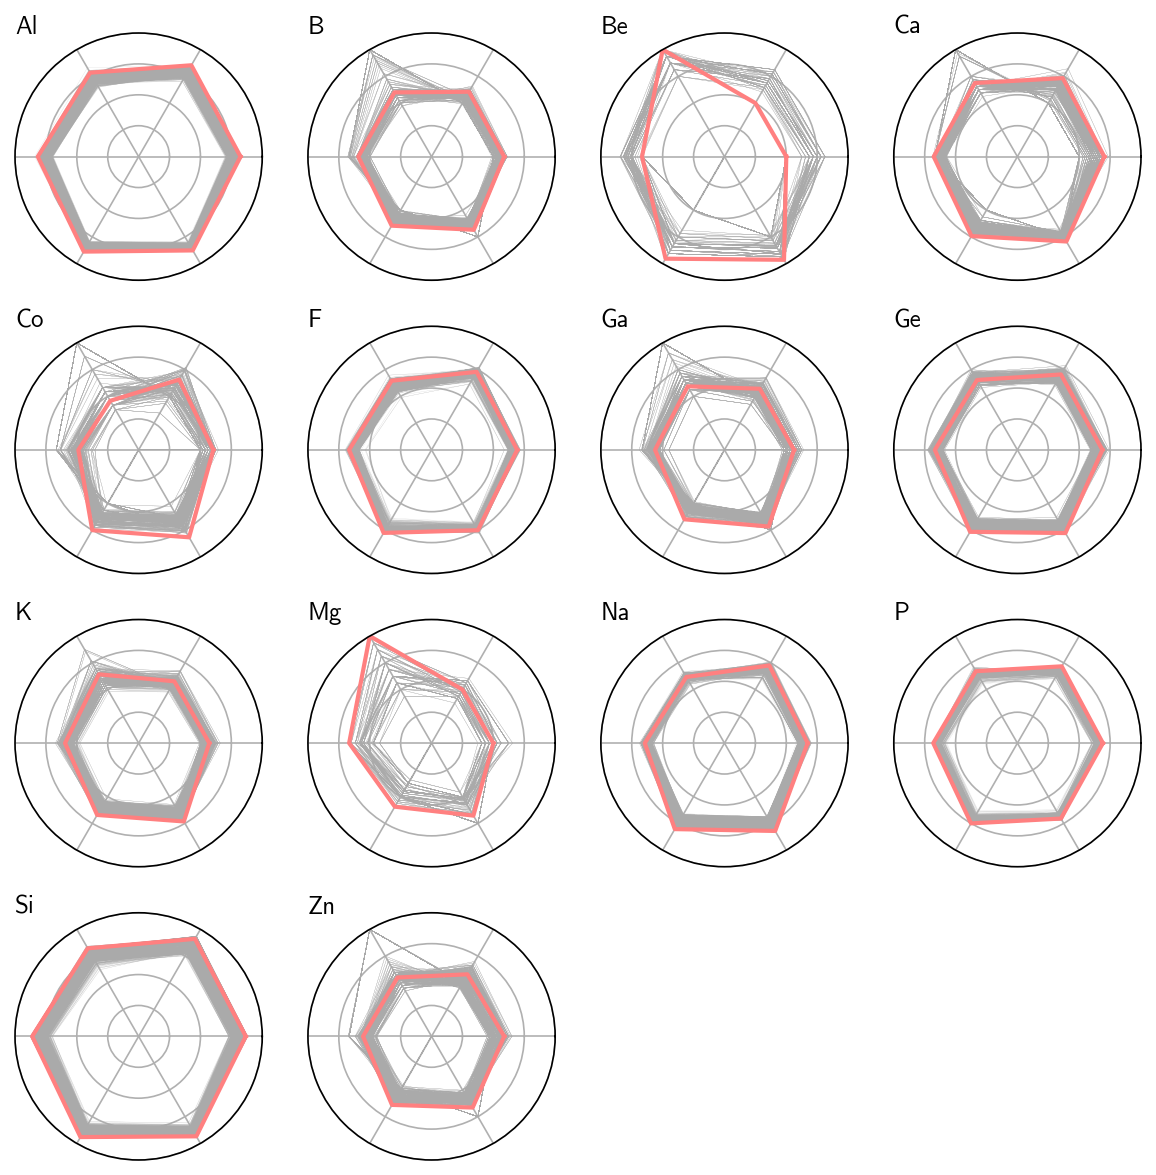

In [ ]:
fig, ax_fig = plt.subplots(4, 4, figsize=(8, 8), subplot_kw=dict(polar=True))

_x = np.arange(len(METRICS))

# Plot a grid of radar charts
for ax, label in zip(ax_fig.reshape(-1), LABELS):
    _df = meandf.loc[(meandf.label == label) & (meandf.classifier == "XGBClassifier")][METRICS]

    # Plot the radar chart
    angles = plot_radar_chart(ax, _df, alpha=0.6, linewidth=0.1)
    
    # Plot the best model 
    best = _df.loc[(_df.values > 0).all(1)].sort_values("val_roc_auc", ascending=False).iloc[:1]
    draw_radar_chart(ax, best, angles, color="#ff8080", alpha=1, linewidth=2)
    
    # Set the ticks and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels([])
    ax.annotate(label, (0., 1.0), xycoords="axes fraction", ha='left')

for ax in ax_fig.reshape(-1)[-2:]:
    ax.axis("off")
    
fig.tight_layout()

savefig(fig, f"04-xgboost-soap-metrics.pdf")
plt.show()

## Selecting the best hyperparameters

For XGBoost model

In [9]:
pr_best = (meandf
    .loc[(meandf[METRICS].values > 0).all(1) & (meandf["classifier"] == "XGBClassifier")]
    .pivot(index="params_str", columns="label", values="val_pr_auc")
)
pr_best = pr_best.dropna(axis=0).mean(1)

In [10]:
roc_best = (meandf
    .loc[(meandf[METRICS].values > 0).all(1) & (meandf["classifier"] == "XGBClassifier")]
    .pivot(index="params_str", columns="label", values="val_roc_auc")
)
roc_best = roc_best.dropna(axis=0).mean(1)

In [11]:
best = pd.concat([pr_best, roc_best], axis=1)
best.columns = ["pr_auc", "roc_auc"]

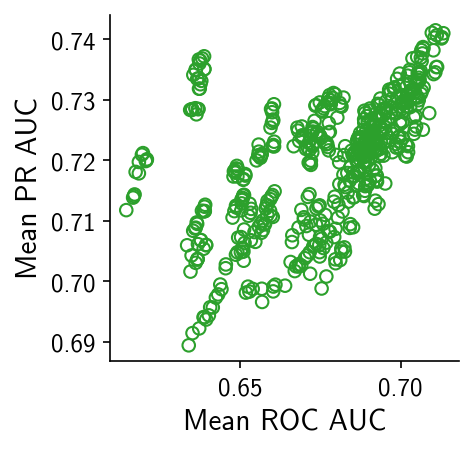

In [12]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(
    best["roc_auc"],
    best["pr_auc"],
    facecolors="none",
    edgecolors=COLORS["XGBClassifier"],
)

ax.set_xlabel("Mean ROC AUC")
ax.set_ylabel("Mean PR AUC")

savefig(fig, f"04-xgboost-soap-best.pdf")
plt.show()

In [13]:
best_params = best.loc[
    (best["roc_auc"] > 0.70)
    & (best["pr_auc"] > 0.73)
].sort_values("roc_auc", ascending=False).head(10)
best_params

,pr_auc,roc_auc
params_str,,
"{""colsample_bytree"": 0.5, ""learning_rate"": 0.1, ""max_depth"": 4, ""min_child_weight"": 1, ""n_estimators"": 100, ""subsample"": 0.5}",0.740980,0.713317
"{""colsample_bytree"": 0.5, ""learning_rate"": 0.1, ""max_depth"": 5, ""min_child_weight"": 1, ""n_estimators"": 100, ""subsample"": 0.5}",0.740321,0.712902
"{""colsample_bytree"": 0.5, ""learning_rate"": 0.1, ""max_depth"": 6, ""min_child_weight"": 1, ""n_estimators"": 100, ""subsample"": 0.5}",0.740121,0.712744
"{""colsample_bytree"": 0.75, ""learning_rate"": 0.1, ""max_depth"": 6, ""min_child_weight"": 1, ""n_estimators"": 100, ""subsample"": 0.5}",0.735407,0.711384
"{""colsample_bytree"": 0.75, ""learning_rate"": 0.1, ""max_depth"": 4, ""min_child_weight"": 1, ""n_estimators"": 200, ""subsample"": 0.75}",0.740647,0.711293
"{""colsample_bytree"": 0.75, ""learning_rate"": 0.1, ""max_depth"": 5, ""min_child_weight"": 1, ""n_estimators"": 100, ""subsample"": 0.5}",0.735397,0.711104
"{""colsample_bytree"": 0.75, ""learning_rate"": 0.1, ""max_depth"": 5, ""min_child_weight"": 1, ""n_estimators"": 200, ""subsample"": 0.75}",0.741459,0.710901
"{""colsample_bytree"": 0.75, ""learning_rate"": 0.1, ""max_depth"": 3, ""min_child_weight"": 1, ""n_estimators"": 100, ""subsample"": 0.5}",0.734527,0.710831
"{""colsample_bytree"": 0.75, ""learning_rate"": 0.1, ""max_depth"": 6, ""min_child_weight"": 1, ""n_estimators"": 200, ""subsample"": 0.75}",0.740239,0.710522


In [14]:
params = best_params.iloc[0].name

## Creating a table of the selected model performance

In [15]:
def create_table(mean, std):
    mean = np.round(mean, 2).applymap(lambda x: f"{x:.2f}")
    std = np.round(std, 2).applymap(lambda x: f"{x:.2f}")
    
    return mean + " ± " + std

TEST_COLS = [c for c in meandf.columns if c.startswith("test_")]

In [16]:
selected_mean = meandf.loc[meandf["params_str"] == params].drop(["classifier", "params_str"], axis=1).set_index("label")
selected_std = stddf.loc[stddf["params_str"] == params].drop(["classifier", "params_str"], axis=1).set_index("label")

In [17]:
table = create_table(selected_mean, selected_std)[TEST_COLS]
table = pd.concat([
    num_points.loc[table.index],
    table,
], axis=1)
table

,n,test_accuracy,test_precision,test_recall,test_F1-score,test_roc_auc,test_pr_auc
label,,,,,,,
Al,200,0.75 ± 0.03,0.77 ± 0.04,0.70 ± 0.05,0.73 ± 0.04,0.83 ± 0.02,0.81 ± 0.04
B,28,0.68 ± 0.17,0.65 ± 0.15,0.82 ± 0.17,0.72 ± 0.14,0.74 ± 0.21,0.78 ± 0.19
Be,12,0.69 ± 0.18,0.65 ± 0.17,1.00 ± 0.00,0.78 ± 0.11,0.80 ± 0.21,0.83 ± 0.20
Ca,24,0.59 ± 0.17,0.64 ± 0.20,0.62 ± 0.13,0.61 ± 0.12,0.69 ± 0.18,0.79 ± 0.11
Co,20,0.55 ± 0.25,0.57 ± 0.22,0.53 ± 0.25,0.54 ± 0.23,0.54 ± 0.25,0.64 ± 0.20
F,74,0.70 ± 0.14,0.77 ± 0.19,0.61 ± 0.10,0.67 ± 0.12,0.73 ± 0.13,0.77 ± 0.10
Ga,22,0.58 ± 0.09,0.61 ± 0.17,0.69 ± 0.22,0.61 ± 0.08,0.66 ± 0.17,0.76 ± 0.12
Ge,54,0.68 ± 0.13,0.67 ± 0.14,0.71 ± 0.18,0.69 ± 0.14,0.71 ± 0.13,0.68 ± 0.13
K,44,0.53 ± 0.07,0.53 ± 0.06,0.61 ± 0.19,0.55 ± 0.10,0.60 ± 0.08,0.67 ± 0.07


In [18]:
print(table.to_latex())

\begin{tabular}{lrllllll}
\toprule
{} &    n & test\_accuracy & test\_precision &  test\_recall & test\_F1-score & test\_roc\_auc &  test\_pr\_auc \\
label &      &               &                &              &               &              &              \\
\midrule
Al    &  200 &   0.75 ± 0.03 &    0.77 ± 0.04 &  0.70 ± 0.05 &   0.73 ± 0.04 &  0.83 ± 0.02 &  0.81 ± 0.04 \\
B     &   28 &   0.68 ± 0.17 &    0.65 ± 0.15 &  0.82 ± 0.17 &   0.72 ± 0.14 &  0.74 ± 0.21 &  0.78 ± 0.19 \\
Be    &   12 &   0.69 ± 0.18 &    0.65 ± 0.17 &  1.00 ± 0.00 &   0.78 ± 0.11 &  0.80 ± 0.21 &  0.83 ± 0.20 \\
Ca    &   24 &   0.59 ± 0.17 &    0.64 ± 0.20 &  0.62 ± 0.13 &   0.61 ± 0.12 &  0.69 ± 0.18 &  0.79 ± 0.11 \\
Co    &   20 &   0.55 ± 0.25 &    0.57 ± 0.22 &  0.53 ± 0.25 &   0.54 ± 0.23 &  0.54 ± 0.25 &  0.64 ± 0.20 \\
F     &   74 &   0.70 ± 0.14 &    0.77 ± 0.19 &  0.61 ± 0.10 &   0.67 ± 0.12 &  0.73 ± 0.13 &  0.77 ± 0.10 \\
Ga    &   22 &   0.58 ± 0.09 &    0.61 ± 0.17 &  0.69 ± 0.22 &   0.61 ±